# Módulo 6 - Aprendizado profundo

Neste notebook, utilizaremos a biblioteca [Keras](https://www.keras.io) para construir uma rede neural do tipo Convolutional Neural Networks (CNN). Neste exemplo, iremos criar uma CNN para classificar imagens do dataset CIFAR-10. As imagens deste dataset são classificadas em 10 categorias. O objetivo é entender como este tipo de rede funciona. Ao final, você deverá realizar os exercícios propostos.

Para começar, precisamos importar algumas bibliotecas.

In [1]:
import keras
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Para utilizar o dataset CIFAR-10, basta executar o comando abaixo.  Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída).

In [2]:
# carrega os conjuntos de treino e teste
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Podemos visualizar alguns exemplos (de entrada e saída) do dataset utilizando o código abaixo.

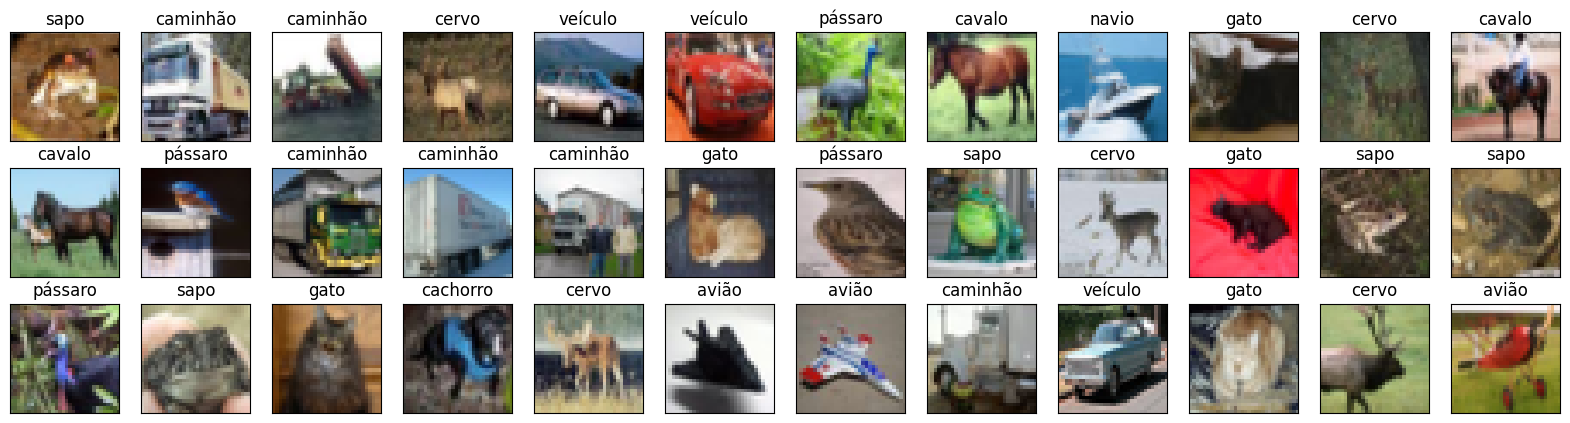

In [3]:
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(cifar10_labels[y_train[i][0]]))

Após carregar os dados, devemos tratá-los para melhorar o treinamento. No nosso caso, vamos apenas normalizar as cores (atualmente no intervalo [0,255]) para o intervalo [0,1].

In [4]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Em seguida, podemos codificar as classes utilizando o one-hot encoding. Isto vai facilitar o aprendizado.

In [5]:
# codificação one-hot das categorias
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Outro passo importante é separar uma parte do conjunto de treino para validação. O objetivo é reduzir o bias do conjunto de teste.

In [6]:
# divide os dados em treino, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Após os tratamentos acima, podemos identificar o formato resultante dos nossos dados com os comandos abaixo.

In [7]:
# imprime o formato dos dados de entrada
print('Formato dos dados de entrada:', x_train.shape)

# imprime o tamanho dos conjuntos
print(x_train.shape[0], 'amostras de treino')
print(x_valid.shape[0], 'amostras de validação')
print(x_test.shape[0], 'amostras de teste')

Formato dos dados de entrada: (45000, 32, 32, 3)
45000 amostras de treino
5000 amostras de validação
10000 amostras de teste


Processados os dados, agora devemos criar a CNN. Como de costume, trabalharemos com um modelo sequencial.

In [8]:
model = Sequential()

Em seguida, podemos empilhar as camadas de convolução e agrupamento desejadas. Neste nosso caso, estamos trabalhando com 3 camadas convolucionais, cada qual com kernel de tamanho 2x2 e função de ativação ReLU. Após cada camada convolucional empilhamos uma camada de max pooling com kernel de tamanho 2x2.

In [9]:
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Lembre-se que as camadas convolucionais servem como um extrator de features, as quais serão utilizadas por um classificador MLP. Desta forma, agora precisamos converter a saída da parte convolucional para um vetor, que é o formato aceito por uma MLP. Isto pode ser feito com uma camada `Flatten`, como abaixo.

In [10]:
model.add(Flatten())

Finalmente, agora podemos adicionar as camadas densas de uma MLP para realizar a classificação. Note também que estamos utilizando Dropout para reduzir o overfitting.

In [11]:
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

Nossa rede resultante é resumida abaixo.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          51,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,304 (243.38 KB)

 Trainable params: 62,304 (243.38 KB)

 Non-trainable params: 0 (0.00 B)

O próximo passo é compilar nosso modelo. Os parâmetros abaixo foram escolhidos por serem próprios para classificação.

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Agora podemos finalmente treinar nosso modelo. **Cuidado, este processo pode demorar bastante!**  Para facilitar o estudo, reduzimos para apenas 10 épocas. Tente aumentar o número de épocas para ver entender melhor o efeito deste parâmetro nos resultados.

Note que antes do treino, criamos um checkpoint. Um checkpoint permite que o modelo seja salvo em um arquivo. No nosso caso, apenas o melhor modelo será salvo. Desta forma, poderemos carregar nosso modelo posteriormente sem precisar treinar novamente a rede.

In [14]:
# Cria um checkpoint para salvar os pesos do melhor modelo encontrado no treinamento
checkpointer = ModelCheckpoint(filepath='model_weights_best.keras', verbose=1, save_best_only=True)

# Treina o modelo
hist = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[checkpointer],
    verbose=1,
    shuffle=True
)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2847 - loss: 1.9346
Epoch 1: val_loss improved from inf to 1.48622, saving model to model_weights_best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2848 - loss: 1.9345 - val_accuracy: 0.4790 - val_loss: 1.4862
Epoch 2/10
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4726 - loss: 1.4663
Epoch 2: val_loss improved from 1.48622 to 1.33483, saving model to model_weights_best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4726 - loss: 1.4662 - val_accuracy: 0.5148 - val_loss: 1.3348
Epoch 3/10
1385/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 1.3082
Epoch 3: val_loss improved from 1.33483 to 1.21498, saving model to model_weights_best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5353 - loss: 1.3080 - val_accuracy: 0.5710 - val_loss: 1.2150
Epoch 4/10
1392/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5752 - loss: 1.2184
Epoch 4: val_l

Treinado o modelo, podemos analisar seu desempenho através dos gráficos abaixo.

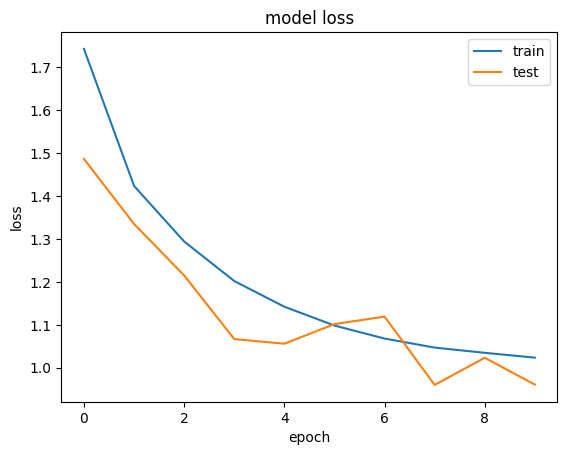

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

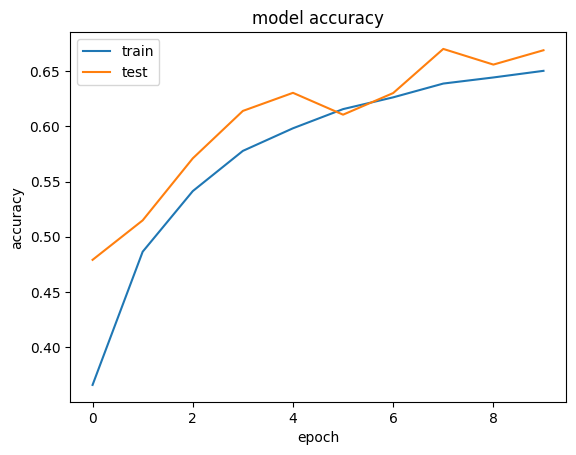

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como pode ser observado, nossa rede CNN conseguiu obter resultados bem interessantes mesmo sem uma otimização dos hiper-parâmetros.

Após concluir o treino, podemos carregar o melhor modelo utilizando o comando abaixo.

In [17]:
# Carrega os pesos do melhor modelo encontrado no treinamento
model.load_weights('model_weights_best.keras')

A acurácia pode ser medida como segue.

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.6650999784469604


Finalmente, podemos visualizar algumas predições do nosso modelo para entender melhor seu comportamento.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


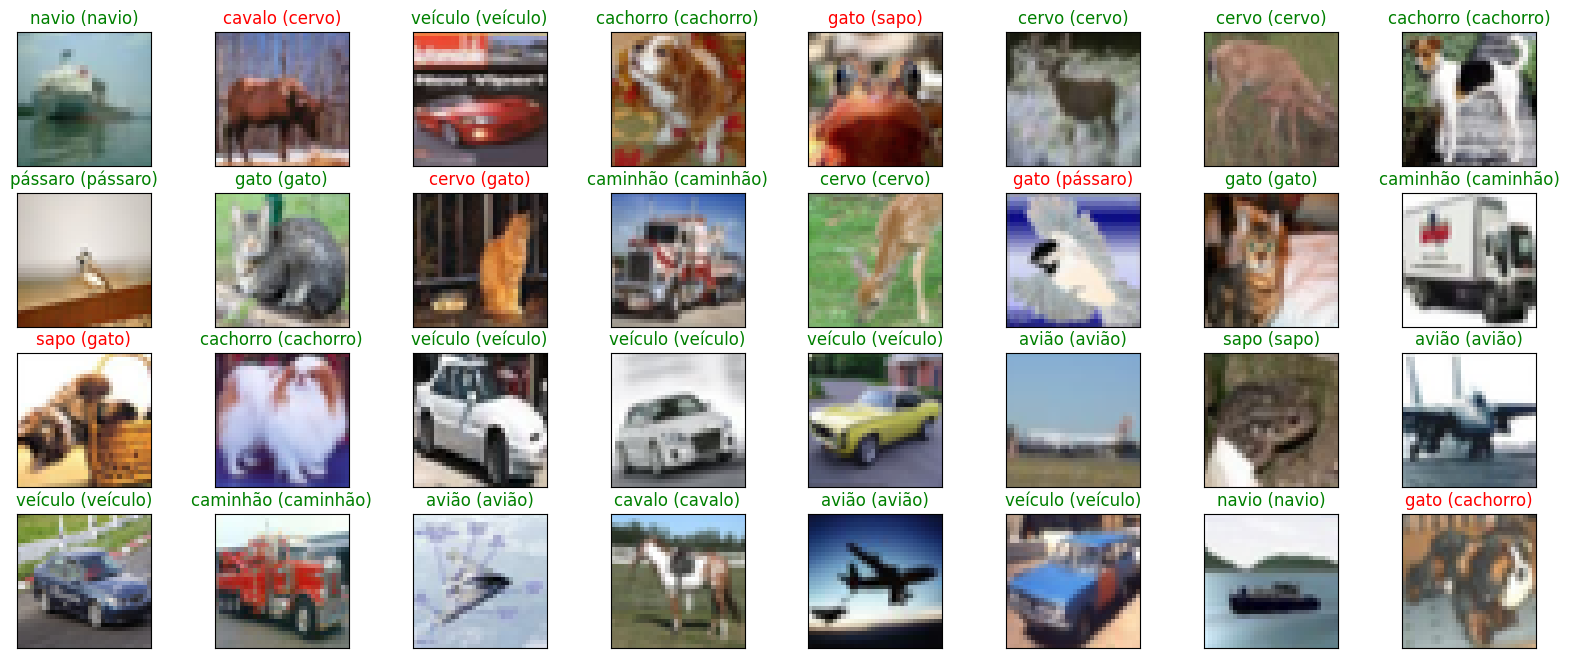

In [19]:
# obtém as predições
y_hat = model.predict(x_test)

# define os labels (fonte: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# exibe alguns exemplos aleatórios do teste, bem como sua predição e o resultado esperado
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

## Exercícios

### Exercício 1

Ajuste a rede CNN vista acima para obter uma acurácia melhor no dataset CIFAR-10. Sua tarefa consiste em modificar a arquitetura da rede (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.).

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2227 - loss: 2.0453
Epoch 1: val_loss improved from inf to 1.43221, saving model to model.weights.best.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.2228 - loss: 2.0450 - val_accuracy: 0.4768 - val_loss: 1.4322
Epoch 2/30
697/704 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4576 - loss: 1.4761
Epoch 2: val_loss improved from 1.43221 to 1.21832, saving model to model.weights.best.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4579 - loss: 1.4754 - val_accuracy: 0.5640 - val_loss: 1.2183
Epoch 3/30
699/704 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5447 - loss: 1.2612
Epoch 3: val_loss improved from 1.21832 to 1.04828, saving model to model.weights.best.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5448 - loss: 1.2610 - val_accuracy: 0.6140 - val_loss: 1.0483
Epoch 4/30
697/704 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5930 - loss: 1.1437
Epoch 4: val_loss improved

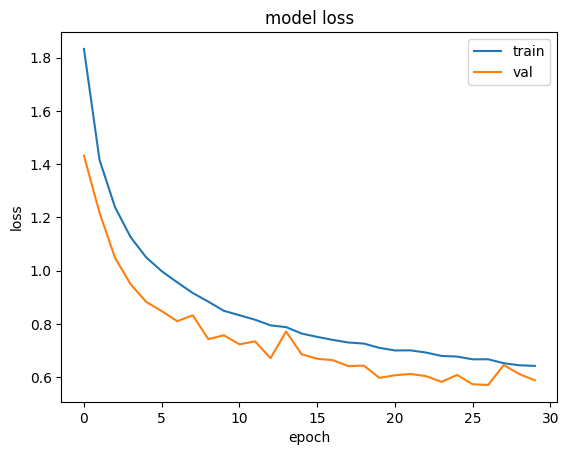

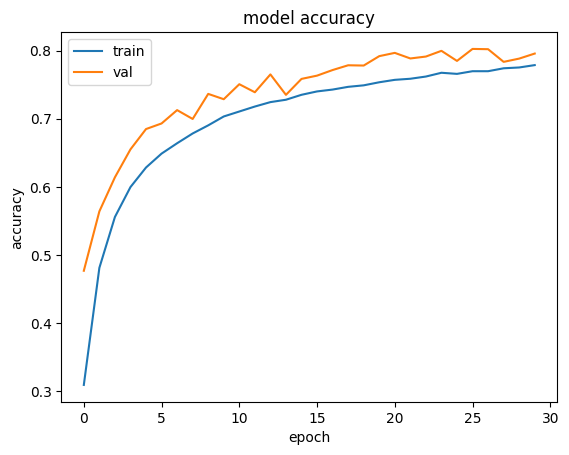

In [20]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True)

hist = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_valid, y_valid),
    callbacks=[checkpointer],
    verbose=1,
    shuffle=True
)

score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
